<a href="https://colab.research.google.com/github/ni-chen/Differentiable-Imaging/blob/main/code/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import sys


work_folder = '/content/drive/My Drive/work/research/1-Differentiable-Imaging/code/'
os.chdir(work_folder)

!pwd


sys.path.append(work_folder)
sys.path.append(f'./function/')


%load_ext autoreload
%autoreload 2


from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))


/content/drive/My Drive/work/research/1-Differentiable-Imaging/code
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

# Tutorial on Differentiable Imaging with PyTorch

## Example 1: How to get the derivatives (code for example in Fig. 3. of the paper)

Calculate $\frac{\partial y}{\partial x_1}$ and $\frac{\partial y}{\partial x_2}$ at $(x_1, x_2)=(2,1)$ for function of $y = \sin(x_1) + x_1 \times x_2$

In [9]:
import torch

x1 = torch.tensor([2.])
x2 = torch.tensor([1.])

x1.requires_grad = True
x2.requires_grad = True

vm = x1
v0 = x2
v1 = torch.sin(vm)
v2 = vm * v0
v3 = v1 + v2
y = v3

vm.retain_grad()
v1.retain_grad()
v2.retain_grad()
v3.retain_grad()

y.backward()

print("partial v3: " + str(v3.grad.item()))
print("partial v2: " + str(v2.grad.item()))
print("partial v1: " + str(v1.grad.item()))
print("partial v0: " + str(v0.grad.item()))
print("partial vm: " + str(vm.grad.item()))


partial v3: 1.0
partial v2: 1.0
partial v1: 1.0
partial v0: 2.0
partial vm: 0.5838531255722046


## Example 2: Optimize phase from a diffraction pattern

$y=\| \mathcal{P}\{exp(j \phi)\} \|^2$

$\mathcal{P}$ is the wave propagation in free-space, $y$ is the diffraction pattern of the phase aberration $\phi$ that represented by Zernike coefficients $c$. We optimize $\phi$ from $y$.

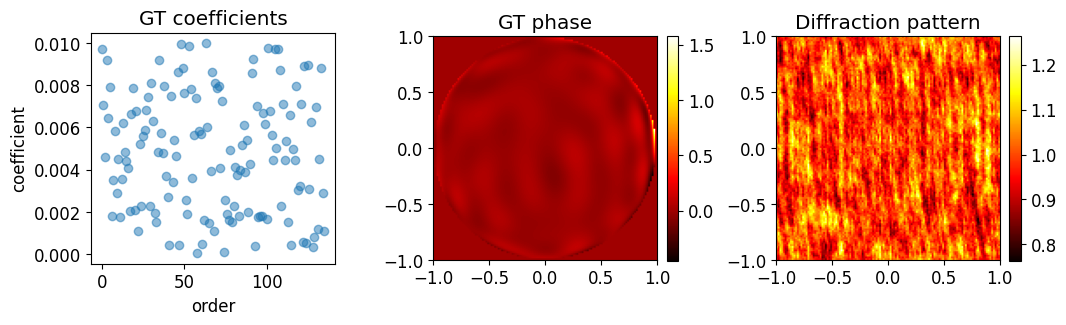

In [23]:
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
from torch import nn

from diffraction import *
from util import *

from function.zernike import RZern

torch.manual_seed(0)

############################### Generate Zernike phase ################################
cart = RZern(15)
Ny, Nx = 128, 128
xx, yy = np.meshgrid(np.linspace(-1.0, 1.0, Nx), np.linspace(-1.0, 1.0, Ny))
cart.make_cart_grid(xx, yy)

c_gt = 0.01 * torch.rand(cart.nk, dtype=torch.double)    # ground truth Zernike coefficients
phi_gt_2d = cart.eval_grid(c_gt, matrix=True).transpose(0, 1).reshape((Nx, Ny))   # ground truth phase

############################ calculate diffraction intensity from phase ############################
params = PropParam()
params.wavelen = torch.tensor([500e-9])
params.pps = torch.tensor([5e-6])
params.z = torch.nn.Parameter(torch.tensor([100e-3], dtype=torch.float32))
params.Nx, params.Ny = Nx, Ny
params = prop_kernel(params)

def forward_model_phase(phi):
    field = torch.exp(1j*phi)
    diffraction_pattern = forward_wave_prop(field, params).abs()**2

    return diffraction_pattern

diffraction_pattern = forward_model_phase(phi_gt_2d)

# display images
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=0.4, hspace=0)

plt.subplot(131)
plt.plot(c_gt, 'o', alpha=0.5)
plt.title('GT coefficients')
plt.xlabel('order')
plt.ylabel('coefficient')

plt.subplot(132)
plt.imshow(phi_gt_2d.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('GT phase')

plt.subplot(133)
plt.imshow(diffraction_pattern.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Diffraction pattern')

plt.show()

### Optimize phase directly

iter = 0: loss = 0.004941986809953388, d_phi=-4.4667753077863494e-23
iter = 100: loss = 0.00010303780594749129, d_phi=-8.06501097239202e-24
iter = 200: loss = 4.0337017885504665e-05, d_phi=-2.5849394142282115e-24
iter = 300: loss = 2.0281055485311703e-05, d_phi=-2.016252743098005e-24
iter = 400: loss = 1.1954731875062368e-05, d_phi=8.142559154818866e-25
iter = 500: loss = 7.93025537914895e-06, d_phi=-6.203854594147708e-25
iter = 600: loss = 5.750834484322154e-06, d_phi=-3.812785635986612e-25
iter = 700: loss = 4.452256078546793e-06, d_phi=1.5962000882859206e-24
iter = 800: loss = 3.6035593283141446e-06, d_phi=-3.42504472385238e-25
iter = 900: loss = 3.001657423721478e-06, d_phi=6.85008944770476e-25


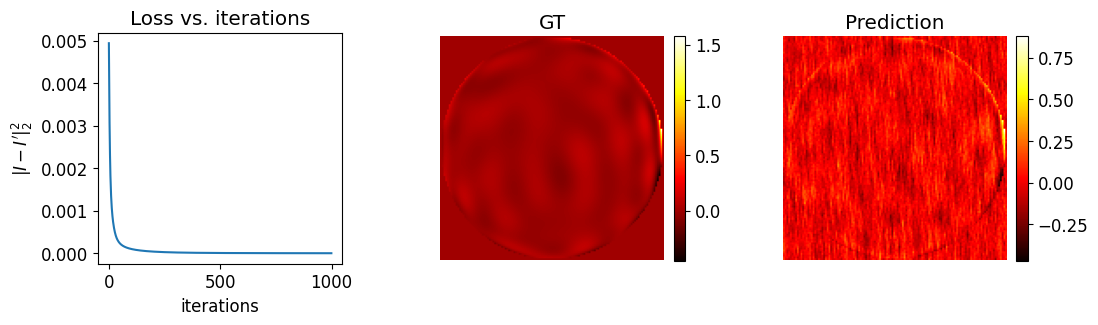

In [20]:
phi_pred = nn.Parameter(0.05*torch.rand([Nx, Ny], dtype=torch.double, requires_grad=True))

loss_hist = []
lr = 0.005
optimizer = optim.Adam([phi_pred], lr=lr)
for iter in range(1000):
    optimizer.zero_grad()     # Essential for update the derivatives

    I_prime = forward_model_phase(phi_pred)
    loss = torch.mean((I_prime - diffraction_pattern)**2)

    loss_hist.append(loss.detach())
    loss.backward(retain_graph=True)     # Calculate the derivatives

    optimizer.step()

    if iter % 100 == 0:
        print("iter = {}: loss = {}, d_phi={}".format(iter, loss.data.numpy(), phi_pred.grad.mean().numpy()))

#########################################################################################
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=0.4, hspace=0)

plt.subplot(131)
plt.plot(loss_hist)
plt.title('Loss vs. iterations')
plt.xlabel('iterations')
plt.ylabel(r'$|I- I^\prime|_2^2$')

plt.subplot(132)
plt.imshow(phi_gt_2d.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('GT')

plt.subplot(133)
plt.imshow(phi_pred.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Prediction')
plt.show()

### Optimize Zernike coefficients

iter = 0: loss = 0.0030508383672001507, c_grad=0.00045242523725383047
iter = 100: loss = 3.4313477125193025e-08, c_grad=3.1013272121932386e-06
iter = 200: loss = 9.303842849196492e-13, c_grad=-6.929551989188195e-09
iter = 300: loss = 2.738056189584794e-17, c_grad=6.417170162280778e-11
iter = 400: loss = 9.69869989206306e-22, c_grad=6.525086007332292e-13
iter = 500: loss = 2.3011086596877034e-26, c_grad=-3.590019757858846e-15
iter = 600: loss = 7.556403836550899e-27, c_grad=1.2994156396585567e-15
iter = 700: loss = 1.9909803505332857e-10, c_grad=-7.723834271587052e-08
iter = 800: loss = 2.9173142197987297e-15, c_grad=-6.266384484004267e-10
iter = 900: loss = 6.952814319980129e-10, c_grad=-4.957175091776662e-07


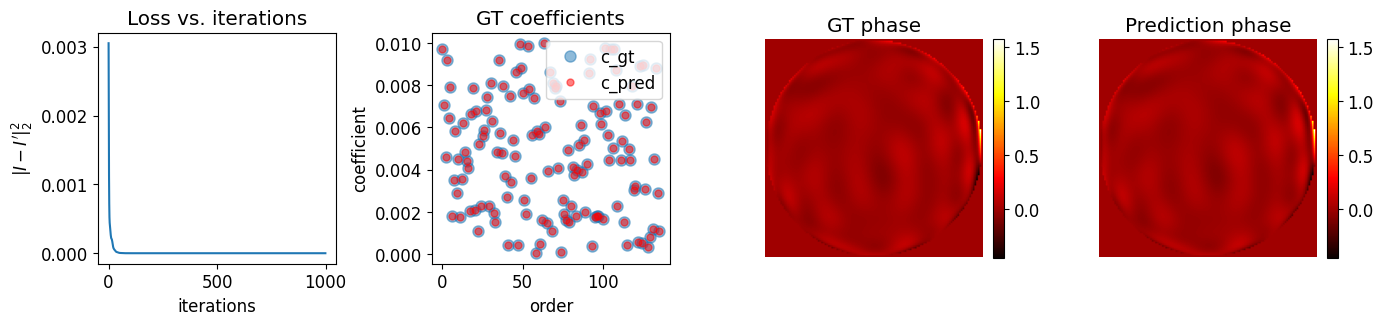

In [17]:
def forward_model_coe(cz):
    phi_2d = cart.eval_grid(cz, matrix=True).transpose(0, 1).reshape((Nx, Ny))

    diffraction_pattern = forward_wave_prop(torch.exp(1j*phi_2d), params).abs()**2

    return diffraction_pattern, phi_2d


c_pred = nn.Parameter(0.01*torch.rand(cart.nk, dtype=torch.double, requires_grad=True))
loss_hist = []
lr = 0.001
optimizer = optim.Adam([c_pred], lr=lr)
for iter in range(1000):
    optimizer.zero_grad()     # Essential for update the derivatives

    I_prime, phi_pred = forward_model_coe(c_pred)
    loss = torch.mean((I_prime - diffraction_pattern)**2)

    loss_hist.append(loss.detach())
    loss.backward(retain_graph=True)     # Calculate the derivatives

    optimizer.step()

    if iter % 100 == 0:
        print("iter = {}: loss = {}, c_grad={}".format(iter, loss.data.numpy(), c_pred.grad.mean().numpy()))

#########################################################################################
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16, 3))
plt.subplots_adjust(wspace=0.4, hspace=0)

plt.subplot(141)
plt.plot(loss_hist)
plt.title('Loss vs. iterations')
plt.xlabel('iterations')
plt.ylabel(r'$|I- I^\prime|_2^2$')

plt.subplot(142)
plt.plot(c_gt, 'o', label='c_gt', markersize=8, alpha=0.5)
plt.plot(c_pred.detach(), 'o', color='red', markersize=5, label='c_pred', alpha=0.5)
plt.legend()
plt.title('GT coefficients')
plt.xlabel('order')
plt.ylabel('coefficient')

plt.subplot(143)
plt.imshow(phi_gt_2d.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('GT phase')

plt.subplot(144)
plt.imshow(phi_pred.detach(), origin='lower', extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('Prediction phase')
plt.show()